# Otimização de Elenco de Futebol: Uma Abordagem Baseada em Dados

**Disciplina:** Otimização (COS360/COM361) - 2025

**Aluno:** Daniel Rebouças de Sousa Barros

**Professor:** Luidi Simonetti

---

## 1. Introdução: O "Moneyball" e a Otimização no Futebol

A gestão de um clube de futebol moderno deixou de ser apenas uma questão de intuição para se tornar um problema complexo de engenharia de dados e pesquisa operacional. Inspirado pelo fenômeno *Moneyball* no beisebol e pelo sucesso de clubes como Brentford e Brighton, este projeto visa resolver o problema da **Montagem de Elenco (Squad Building)** sob restrições financeiras rígidas.

### 1.1. Definição do Problema
O objetivo é gerenciar o elenco do **Flamengo** ao longo de **4 janelas de transferência (2 anos)**. O modelo não deve apenas escolher os melhores jogadores hoje, mas planejar o futuro:
* Contratar jogadores jovens com alto potencial de valorização.
* Vender jogadores em declínio antes que seu valor de mercado despenque.
* Manter a "química" (entrosamento) do time, evitando rotação excessiva.

O problema é modelado como um **Problema de Programação Inteira Mista (MILP)**, considerando restrições orçamentárias (Salário e Transferências) e táticas (formação e cobertura de posições).

In [73]:
import pandas as pd
import numpy as np
import time
import pulp

In [74]:
# --- CONSTANTES GLOBAIS ---
ANO_REFERENCIA = 2025  # Ano base para cálculo de idade (reprodutibilidade)

# --- 1. Arquivos e Time ---
ARQUIVO_DADOS_PRINCIPAL = "player-data-full.csv"
ARQUIVO_DADOS_CUSTOM = "flamengo_custom_players.csv"
TIME_ESCOLHIDO = "Flamengo"
LIGA_TIME = "Premier League"
NUM_JANELAS = 4

# --- 2. Parâmetros Financeiros ---
TRANSFER_BUDGET_INICIAL = 40.0  
PERCENTUAL_FOLGA_SALARIAL = 0.2  # +20% sobre folha atual
VALOR_MAX_JOGADOR = 250.0  # Teto para poda (€80M)

TAXA_TRANSACAO_COMPRA = 0.12
TAXA_TRANSACAO_VENDA = 0.10
TAXA_BONUS_ASSINATURA = 0.75 

# --- 3. Parâmetros de Poda (Performance) ---
K_MERCADO_POR_POS = 400  # Top-K jogadores por posição
K_PARES_POR_JOGADOR = 12  # <-- Modelo O(N^2) de Pares está ATIVO

# --- 4. Filosofia (Pesos da Função Objetivo) ---
w_qualidade = 0.5  # Overall rating
w_potencial = 0.4  # Growth potential
w_fisico = 0.1     # Physical

# Validação automática
assert abs(w_qualidade + w_potencial + w_fisico - 1.0) < 1e-6, \
    "❌ ERRO: Pesos devem somar 1.0!"

# --- 5. Parâmetros de Química (Estoque S) ---
DECAY_QUIMICA = 0.9  
GAIN_TITULARES = 1.0  
GAIN_RESERVA = 0.2   
BONUS_ENTROSAMENTO = 10.0 # <-- Mantendo o bônus alto
QUIMICA_INICIAL_LEGADO = 15

# --- CALIBRAGEM DE PENALIDADES (SOFT CONSTRAINTS) ---
# 1. Lambda Turnover: Penalidade por contratação (evita churn)
LAMBDA_TURNOVER = 10

# 2. Penalty Slack: Penalidade GIGANTE por não cumprir requisitos de posição
# Isso garante que ele só viole a regra de "mínimo de goleiros" se for impossível pagar.
PENALTY_SLACK_POSICAO = 500.0 

# --- 6. Parâmetros do Solver ---
GAP_RELATIVO = 0.01  # 1% de otimalidade
LIMITE_TEMPO = 1800  # 30 minutos

In [75]:
# --- [CARREGAMENTO E LIMPEZA DOS DADOS PRINCIPAIS] ---

print(f"Carregando {ARQUIVO_DADOS_PRINCIPAL}...")
try:
    player_data = pd.read_csv(ARQUIVO_DADOS_PRINCIPAL)
except FileNotFoundError:
    print(f"Erro: Arquivo {ARQUIVO_DADOS_PRINCIPAL} não encontrado.")
    # (Adicione uma parada ou lógica de erro aqui)

# Define as colunas que realmente usaremos
cols_necessarias = [
    "name", "dob", "country_name", "positions", "overall_rating", "potential", 
    "value", "wage", "club_name", "club_league_name", 
    "acceleration", "agility", "strength", "stamina"
]
players_raw = player_data[cols_necessarias].copy()

Carregando player-data-full.csv...


/var/folders/k8/xzk1z07s6c58p_hh_nnx6nk40000gn/T/ipykernel_56288/2171995104.py:5: DtypeWarning: Columns (15,16,34,35,36,37,39,73) have mixed types. Specify dtype option on import or set low_memory=False.
  player_data = pd.read_csv(ARQUIVO_DADOS_PRINCIPAL)


# Funções de pré-processamento

In [76]:
# --- [DEFINIÇÃO: FUNÇÕES DE PRÉ-PROCESSAMENTO] ---

def converter_valor_monetario_vetorizado(serie):
    """
    Converte Series do Pandas com valores monetários (ex: '€10.5M', '€200K') para float.
    
    Usa operações vetorizadas para máxima performance (~10-100x mais rápido que .apply()).
    
    Args:
        serie (pd.Series): Série com valores monetários como strings
        
    Returns:
        pd.Series: Série com valores numéricos em euros
    """
    # Remove símbolo € e espaços
    serie_limpa = serie.astype(str).str.replace('€', '', regex=False).str.strip()
    
    # Cria máscaras booleanas para identificar sufixos
    mask_m = serie_limpa.str.contains('M', na=False)
    mask_k = serie_limpa.str.contains('K', na=False)
    
    # Inicializa resultado com zeros
    resultado = pd.Series(0.0, index=serie.index)
    
    # Processa valores com 'M' (milhões)
    resultado[mask_m] = pd.to_numeric(
        serie_limpa[mask_m].str.replace('M', '', regex=False), 
        errors='coerce'
    ) * 1_000_000
    
    # Processa valores com 'K' (milhares)
    resultado[mask_k] = pd.to_numeric(
        serie_limpa[mask_k].str.replace('K', '', regex=False), 
        errors='coerce'
    ) * 1_000
    
    # Processa valores sem sufixo
    mask_sem_sufixo = ~mask_m & ~mask_k
    resultado[mask_sem_sufixo] = pd.to_numeric(
        serie_limpa[mask_sem_sufixo], 
        errors='coerce'
    )
    
    # Substitui NaN por 0
    return resultado.fillna(0.0)

def processar_dataframe(df_raw):
    """
    Executa pipeline completo de pré-processamento para dados de jogadores.
    
    Transformações aplicadas:
    1. Conversão de valores monetários (€M/€K → float)
    2. Cálculo de idade a partir da data de nascimento
    3. Criação de métrica composta 'physical' (média de 4 atributos físicos)
    4. Cálculo de potencial de crescimento (potential - overall_rating)
    5. Extração de posição principal e secundárias
    6. Cálculo de versatilidade (número de posições)
    7. Limpeza e padronização de colunas
    
    Args:
        df_raw (pd.DataFrame): DataFrame bruto com dados de jogadores
        
    Returns:
        pd.DataFrame: DataFrame processado com features engenheiradas
        
    Raises:
        KeyError: Se colunas essenciais estiverem faltando
        
    Example:
        >>> players_df = processar_dataframe(raw_data)
        >>> print(players_df[['name', 'overall_rating', 'physical']].head())
    """
    ANO_REFERENCIA = 2025  # Fixo para reprodutibilidade
    
    print("⏳ Iniciando pré-processamento do DataFrame...")

    df_raw['value_eur'] = converter_valor_monetario_vetorizado(df_raw['value']) / 1_000_000.0
    df_raw['wage_eur'] = converter_valor_monetario_vetorizado(df_raw['wage']) / 1_000_000.0

    # 2. Idade
    df_raw['age'] = ANO_REFERENCIA - pd.to_datetime(df_raw['dob'], errors='coerce').dt.year
    df_raw['age'] = df_raw['age'].fillna(df_raw['age'].median()).astype(int)
    
    # 3. Métrica Física Composta
    df_raw['physical'] = (
        (df_raw['stamina'] + df_raw['strength'] + 
         df_raw['acceleration'] + df_raw['agility']) / 4
    ).round(0).astype(int)
    
    # 4. Potencial de Crescimento
    df_raw['growth_potential'] = df_raw['potential'] - df_raw['overall_rating']
    
    # 5. Posições
    df_raw['main_position'] = df_raw['positions'].str.split(',').str[0].str.strip()
    df_raw['sec_positions'] = df_raw['positions'].str.split(',').str[1:].str.join(', ').str.strip()
    df_raw['versatility'] = df_raw['positions'].str.split(',').str.len()
    
    # 6. Seleção Final de Colunas
    cols_finais = [
        "name", "age", "country_name", "main_position", "sec_positions", 
        "overall_rating", "potential", "growth_potential", "value", "wage", 
        "club_name", "club_league_name", "physical", "versatility", 
        "value_eur", "wage_eur"
    ]
    
    df_processado = df_raw[cols_finais].copy()
    
    # 7. Tratamento de valores nulos críticos
    df_processado['wage_eur'] = df_processado['wage_eur'].fillna(0)
    df_processado['value_eur'] = df_processado['value_eur'].fillna(0)
    
    print(f"✅ Pré-processamento concluído. Shape: {df_processado.shape}")
    return df_processado

# Executa o processamento
players_df = processar_dataframe(players_raw)
players_df.head()

⏳ Iniciando pré-processamento do DataFrame...
✅ Pré-processamento concluído. Shape: (18331, 16)


,name,age,country_name,main_position,sec_positions,overall_rating,potential,growth_potential,value,wage,club_name,club_league_name,physical,versatility,value_eur,wage_eur
0,Erling Haaland,25,Norway,ST,,91,94,3,€185M,€340K,Manchester City,Premier League,82,1,185.0,0.34
1,Kylian Mbappé,27,France,ST,LW,91,94,3,€181.5M,€230K,Paris Saint Germain,Ligue 1,89,2,181.5,0.23
2,Kevin De Bruyne,34,Belgium,CM,CAM,91,91,0,€103M,€350K,Manchester City,Premier League,78,2,103.0,0.35
3,Rodri,29,Spain,CDM,CM,90,91,1,€122.5M,€260K,Manchester City,Premier League,74,2,122.5,0.26
4,Harry Kane,32,England,ST,,90,90,0,€119.5M,€170K,FC Bayern München,Bundesliga,74,1,119.5,0.17


In [77]:
# --- [MONTAGEM DO ELENCO INICIAL] ---

# PARÂMETRO DE CONTROLE:
USAR_DADOS_CUSTOMIZADOS = False 

print(f"Montando elenco para: {TIME_ESCOLHIDO} ({LIGA_TIME})...")

# 1. LÓGICA DE LIMPEZA (O "Clean Slate")
# Se for Flamengo, removemos TODOS os jogadores originais desse time do dataset.
# Isso evita duplicatas se você importar um "Pedro" customizado e já existir um "Pedro" original.
if TIME_ESCOLHIDO == "Flamengo":
    print(f"🧹 LIMPEZA: Removendo elenco original do {TIME_ESCOLHIDO} para montagem do zero...")
    players_df = players_df[players_df['club_name'] != TIME_ESCOLHIDO].copy()

# 2. LÓGICA DE INJEÇÃO DE JOGADORES
if TIME_ESCOLHIDO == "Flamengo" or USAR_DADOS_CUSTOMIZADOS:
    
    print("⚡ MODO CUSTOMIZADO: Injetando jogadores manuais e externos...")

    # A. Jogadores "Legado" (Transferência Manual de outros times)
    jogadores_para_mudar = [
        {'name': 'Samuel Lino', 'club_name': None},
        {'name': 'Saúl', 'club_name': "Atlético Madrid"},
        {'name': 'Jorginho', 'club_name': None},
        {'name': 'Emerson Royal', 'club_name': None},
        {'name': 'Michael', 'club_name': None},
        {'name': 'Danilo', 'club_name': 'Juventus'},
        {'name': 'Alex Sandro', 'club_name': 'Juventus'},
    ]

    count_legado = 0
    for jogador in jogadores_para_mudar:
        nome_jogador = jogador['name']
        clube_original = jogador['club_name']
        
        # Procura o jogador no dataset restante (lembrando que o Flamengo original já foi apagado)
        condicao = (players_df['name'] == nome_jogador)
        if clube_original:
            condicao &= (players_df['club_name'] == clube_original)
        
        if players_df.loc[condicao].shape[0] > 0:
            players_df.loc[condicao, ['club_name', 'club_league_name']] = [TIME_ESCOLHIDO, LIGA_TIME]
            print(f"     [Transferido] {nome_jogador} -> {TIME_ESCOLHIDO}")
            count_legado += 1
        else:
            # Opcional: Avisar só se não for um dos que deletamos propositalmente
            pass 

    # B. Jogadores Customizados (CSV Externo)
    print(f"  -> Carregando arquivo: {ARQUIVO_DADOS_CUSTOM}...")
    try:
        df_novos_jogadores = pd.read_csv(ARQUIVO_DADOS_CUSTOM)
        
        # Configura colunas obrigatórias
        df_novos_jogadores['club_name'] = TIME_ESCOLHIDO
        df_novos_jogadores['club_league_name'] = LIGA_TIME
        
        # Tratamento numérico igual ao da função de pré-processamento
        # (Assumindo que no CSV os valores já vêm limpos ou precisam apenas de escala)
        if df_novos_jogadores['value_eur'].dtype == object:
             # Se vier com "M" ou "€", precisaria da função de conversão, 
             # mas geralmente CSV customizado vem limpo. Vamos garantir:
             pass 
        else:
             # Se já for numérico mas estiver em milhões, ajuste conforme seu CSV.
             # O código anterior dividia por 1M. Ajuste se necessário.
             df_novos_jogadores['value_eur'] = df_novos_jogadores['value_eur'] / 1_000_000.0
             df_novos_jogadores['wage_eur'] = df_novos_jogadores['wage_eur'] / 1_000_000.0

        # Feature Engineering básica para os novos
        df_novos_jogadores['growth_potential'] = df_novos_jogadores['potential'] - df_novos_jogadores['overall_rating']
        df_novos_jogadores['versatility'] = 1 + df_novos_jogadores['sec_positions'].str.count(',').fillna(0)
        
        # Concatena ao dataset principal
        players_df = pd.concat([players_df, df_novos_jogadores], ignore_index=True)
        print(f"     [CSV] {len(df_novos_jogadores)} jogadores adicionados.")

    except FileNotFoundError:
        print(f"     [Info] Arquivo {ARQUIVO_DADOS_CUSTOM} não encontrado.")
    except Exception as e:
        print(f"     [Erro] Falha no CSV customizado: {e}")

else:
    print("⏩ MODO PADRÃO: Usando elenco original do dataset.")


# --- CORREÇÃO DO ERRO 'df not defined' ---
# Definimos 'df' explicitamente como o resultado final de todo o processamento acima.
df = players_df.copy()

# Conferência Final
elenco_final = df[df['club_name'] == TIME_ESCOLHIDO]
print(f"\n--- Elenco Inicial Definido: {len(elenco_final)} jogadores ---")
print(f"Total de jogadores no Universo (df): {len(df)}")
display(elenco_final.head(10))

Montando elenco para: Flamengo (Premier League)...
🧹 LIMPEZA: Removendo elenco original do Flamengo para montagem do zero...
⚡ MODO CUSTOMIZADO: Injetando jogadores manuais e externos...
     [Transferido] Samuel Lino -> Flamengo
     [Transferido] Saúl -> Flamengo
     [Transferido] Jorginho -> Flamengo
     [Transferido] Emerson Royal -> Flamengo
     [Transferido] Michael -> Flamengo
     [Transferido] Danilo -> Flamengo
     [Transferido] Alex Sandro -> Flamengo
  -> Carregando arquivo: flamengo_custom_players.csv...
     [CSV] 21 jogadores adicionados.

--- Elenco Inicial Definido: 28 jogadores ---
Total de jogadores no Universo (df): 18332


,name,age,country_name,main_position,sec_positions,overall_rating,potential,growth_potential,value,wage,club_name,club_league_name,physical,versatility,value_eur,wage_eur
177,Jorginho,34,Italy,CDM,CM,83,83,0,€25.5M,€125K,Flamengo,Premier League,72.0,2.0,25.5,0.125
337,Saúl,31,NaN,CM,,81,81,0,€25.5M,€65K,Flamengo,Premier League,72.0,1.0,25.5,0.065
355,Danilo,34,NaN,CB,RB,81,81,0,€17.5M,€100K,Flamengo,Premier League,72.0,2.0,17.5,0.100
509,Samuel Lino,26,NaN,LM,LWB,79,84,5,€26.5M,€48K,Flamengo,Premier League,78.0,2.0,26.5,0.048
895,Emerson Royal,26,NaN,RB,CB,77,79,2,€12.5M,€56K,Flamengo,Premier League,74.0,2.0,12.5,0.056
1087,Alex Sandro,34,NaN,CB,LB,77,77,0,€7M,€77K,Flamengo,Premier League,73.0,2.0,7.0,0.077
1195,Michael,29,NaN,RM,LM,76,76,0,€8M,€36K,Flamengo,Premier League,78.0,2.0,8.0,0.036
18311,Agustín Rossi,28,Argentina,GK,NaN,79,79,0,€12.5M,€29K,Flamengo,Premier League,74.0,1.0,12.5,0.029
18312,Guillermo Varela,31,Uruguay,RB,LB,76,76,0,€5.5M,€35K,Flamengo,Premier League,73.0,1.0,5.5,0.035
18313,Léo Ortiz,28,Brazil,CB,CDM,80,80,0,€18M,€47K,Flamengo,Premier League,77.0,1.0,18.0,0.047


## 2. Metodologia de Simulação: O "Almanaque"

Diferente de problemas estáticos (onde os dados não mudam), o futebol é dinâmico. Um jogador de 19 anos hoje será melhor e mais caro daqui a 2 anos; um de 34 anos provavelmente perderá desempenho.

Para capturar essa dinâmica num modelo de otimização linear, utilizamos uma abordagem de **Pré-cálculo Determinístico (Almanaque)**:

1.  **Projeção de Atributos:** Estimamos o *Overall Rating* futuro baseando-nos na idade atual e no potencial do jogador (curvas de crescimento logarítmicas para jovens e decaimento para veteranos).
2.  **Projeção Financeira:** O valor de mercado e o salário são ajustados a cada janela simulada, permitindo que o modelo decida o momento ótimo de comprar (na baixa) e vender (na alta).

Isso transforma o problema estocástico em um problema determinístico multi-período, permitindo o uso de solvers MILP tradicionais.

In [78]:
# --- [DEFINIÇÃO: FUNÇÕES DE SIMULAÇÃO DE EVOLUÇÃO] ---

def calcular_mudanca_anual_ovr_suavizada(age, current_ovr, potential):
    """Calcula a mudança de OVR base (crescimento + declínio) para um ano."""
    
    # 1. Crescimento (só ocorre se OVR < Potencial)
    if current_ovr >= potential:
        growth = 0
    else:
        # Fases de crescimento
        if age < 22:
            growth = np.random.uniform(1.5, 4)
        elif age < 27:
            growth = np.random.uniform(1, 3)
        elif age < 30:
            growth = np.random.uniform(0, 1)
        else:
            growth = 0 # Para de crescer por idade após os 30

    # 2. Declínio (só ocorre após os 30)
    if age < 30:
        decline = 0
    elif age < 33:
        decline = np.random.uniform(-1, 0)
    elif age < 36:
        decline = np.random.uniform(-2, -1)
    else:
        decline = np.random.uniform(-4, -2)

    return growth + decline

def evoluir_valor_uma_janela(jogador_stats_anterior, novas_stats):
    """
    Calcula o NOVO valor de forma INCREMENTAL, baseado no valor ANTERIOR.
    *** VERSÃO ESCALADA (divide por 1e6) ***
    """
    valor_anterior = jogador_stats_anterior['value_eur'] # Ex: 18.0 (milhões)
    
    # 1. Mudança por OVR
    ovr_change = novas_stats['overall_rating'] - jogador_stats_anterior['overall_rating']
    mult_ovr = 1.0 + (ovr_change * np.random.uniform(0.08, 0.12))
    
    # 2. Mudança por Idade (só se aplica no verão, quando a idade muda)
    mult_idade = 1.0
    age_change = novas_stats['age'] - jogador_stats_anterior['age']
    
    if age_change > 0: # Idade mudou (janela de verão)
        age = novas_stats['age']
        if age < 29:
            mult_idade = 1.05 # Valorização
        elif age < 32:
            mult_idade = 0.93 # Declínio suave
        elif age < 35:
            mult_idade = 0.88 # Declínio
        else:
            mult_idade = 0.82 # Declínio acentuado
            
    # 3. Bônus de Especulação (para potencial de crescimento)
    mult_potencial = 1.0
    if novas_stats['growth_potential'] > 0:
        mult_potencial = 1.0 + (novas_stats['growth_potential'] * 0.015) 
        
    fator_aleatorio = np.random.uniform(0.98, 1.02)
    
    novo_valor = valor_anterior * mult_ovr * mult_idade * mult_potencial * fator_aleatorio
    
    # --- [INÍCIO DA CORREÇÃO] ---
    # O piso de €1M agora é 1.0
    piso_valor_elite = 1.0 
    
    if novas_stats['overall_rating'] > 80 and novo_valor < piso_valor_elite:
        novo_valor = max(novo_valor, piso_valor_elite)
    
    # Garante um valor mínimo para qualquer jogador (ex: 0.01 = €10k)
    novo_valor = max(novo_valor, 0.01)
        
    # Arredonda para 3 casas decimais (ex: 18.525 milhões)
    return round(novo_valor, 3)
    # --- [FIM DA CORREÇÃO] ---


def evoluir_jogador_uma_janela(jogador_stats, t):
    """Função principal que evolui um jogador por uma janela (6 meses)."""
    novas_stats = jogador_stats.copy()
    
    # 1. Atualiza a Idade (só no verão, t=2, t=4...)
    if t > 0 and t % 2 == 0:
        novas_stats['age'] = jogador_stats['age'] + 1
    
    # 2. Evolui Overall e Físico
    mudanca_anual_ovr = calcular_mudanca_anual_ovr_suavizada(
        novas_stats['age'], novas_stats['overall_rating'], novas_stats['potential']
    )
    mudanca_anual_fisico = 0
    if novas_stats['age'] > 29:
        mudanca_anual_fisico = np.random.uniform(-2, 0)
    
    fator_aleatorio_forma = np.random.normal(0, 0.5) 
    
    mudanca_ovr_janela = (mudanca_anual_ovr / 2) + fator_aleatorio_forma
    mudanca_fisico_janela = mudanca_anual_fisico / 2
    
    gap_potencial = novas_stats['potential'] - novas_stats['overall_rating']
    if mudanca_ovr_janela > 0 and mudanca_ovr_janela > gap_potencial:
        mudanca_ovr_janela = max(0, gap_potencial)
    
    novas_stats['overall_rating'] = int(round(novas_stats['overall_rating'] + mudanca_ovr_janela))
    novas_stats['physical'] = int(round(novas_stats['physical'] + mudanca_fisico_janela))
    
    if novas_stats['overall_rating'] > novas_stats['potential']:
        novas_stats['overall_rating'] = novas_stats['potential']
        
    novas_stats['growth_potential'] = novas_stats['potential'] - novas_stats['overall_rating']
    
    # 4. Evolui o Valor (agora chama a função corrigida)
    novas_stats['value_eur'] = evoluir_valor_uma_janela(jogador_stats, novas_stats)
    
    return novas_stats

In [79]:
# --- [DEFINIÇÃO: LÓGICA DE TÁTICA E QUÍMICA] ---

# 1. Dicionário de Mapeamento de Posições
# (Converte posições do FIFA para posições agregadas do modelo)
mapa_posicoes = {
    'GK': 'GK', 'CB': 'CB', 'LB': 'LFB', 'RB': 'RFB', 'LWB': 'LFB',
    'RWB': 'RFB', 'CDM': 'MC', 'CM': 'MC', 'CAM': 'MC', 'LW': 'LWG',
    'RW': 'RWG', 'LM': 'LWG', 'RM': 'RWG', 'ST': 'ST', 'CF': 'ST'
}

# 2. Requisitos de Posição (Profundidade do Elenco)
# (O elenco final deve ter no mínimo X jogadores para cada posição agregada)
requisitos_posicao = {
    'GK': 3, 'CB': 4, 'LFB': 2, 'RFB': 2, 'MC': 7, 'LWG': 2, 'RWG': 2, 'ST': 3
}

# 3. Formação Titular (4-3-3)
# (Define a escalação titular que o modelo deve preencher)
formacao_titular = {
    'GK': 1, 'CB': 2, 'LFB': 1, 'RFB': 1, 'MC': 3, 'LWG': 1, 'RWG': 1, 'ST': 1
}
NUM_TITULARES = sum(formacao_titular.values()) # = 11

# 4. Pares Táticos (Quais posições "conversam" para química)
pares_taticos_set = {
    ('GK', 'CB'), ('CB', 'CB'), ('CB', 'LFB'), ('CB', 'RFB'), ('LFB', 'RFB'),
    ('LFB', 'MC'), ('RFB', 'MC'), ('CB', 'MC'), ('LFB', 'LWG'), ('RFB', 'RWG'),
    ('MC', 'MC'), ('MC', 'LWG'), ('MC', 'RWG'), ('MC', 'ST'),
    ('LWG', 'RWG'), ('LWG', 'ST'), ('RWG', 'ST'), ('ST', 'ST')
}
# Cria um conjunto simétrico (ex: (CB, GK) é o mesmo que (GK, CB))
pares_taticos = set(pares_taticos_set)
for (a, b) in pares_taticos_set:
    pares_taticos.add((b, a))

print(f"Definições de Tática e Química carregadas. {len(pares_taticos)} pares táticos definidos.")

Definições de Tática e Química carregadas. 33 pares táticos definidos.


In [80]:
# --- [PIPELINE ETAPA 1: PODA DO MERCADO] ---
print("Iniciando Poda 1: Filtrando mercado (Top-K por Posição)...")

# 1. Definir Elenco Atual e Mercado Completo
mercado_completo = df[df['club_name'] != TIME_ESCOLHIDO].copy()
elenco_atual = df[df['club_name'] == TIME_ESCOLHIDO].copy()

# 2. Adicionar Posição Agregada para o filtro
mercado_completo['posicao_agregada'] = mercado_completo['main_position'].map(mapa_posicoes)
mercado_completo = mercado_completo.dropna(subset=['posicao_agregada'])

# 3. Aplicar Filtro Top-K por Posição
mercado_filtrado_ids = set()
for pos in requisitos_posicao.keys():
    candidatos_pos = mercado_completo[
        (mercado_completo['posicao_agregada'] == pos) &
        (mercado_completo['value_eur'] <= VALOR_MAX_JOGADOR)
    ].nlargest(K_MERCADO_POR_POS, 'overall_rating')
    
    mercado_filtrado_ids.update(candidatos_pos.index)

# 'mercado' é o dataframe final podado que usaremos
mercado = mercado_completo.loc[list(mercado_filtrado_ids)].copy()

print(f"Mercado reduzido de {len(mercado_completo)} para {len(mercado)} jogadores.")

# 4. Calcular Orçamento Salarial Dinâmico
salario_anual_atual_t0 = elenco_atual['wage_eur'].sum() * 52
WAGE_BUDGET_YEAR = salario_anual_atual_t0 * (1 + PERCENTUAL_FOLGA_SALARIAL)

print(f"\nSalário Anual Atual (t=0): €{salario_anual_atual_t0:,.0f}")
print(f"Teto Salarial Definido (Atual + {PERCENTUAL_FOLGA_SALARIAL:.0%}): €{WAGE_BUDGET_YEAR:,.0f}")

# 5. Definir Tamanho Máximo do Elenco
TAMANHO_MAX_ELENCO = 30

Iniciando Poda 1: Filtrando mercado (Top-K por Posição)...
Mercado reduzido de 18304 para 3200 jogadores.

Salário Anual Atual (t=0): €63
Teto Salarial Definido (Atual + 20%): €76


In [81]:
# --- [INSERIR NOVA CÉLULA DE DEBUG APÓS A CÉLULA 8] ---

print("\n" + "="*60)
print("🔬 VALIDANDO VIABILIDADE DE POSIÇÕES (PRÉ-SOLVER)")
print("="*60)

# 1. Mapear posições do elenco atual (que não tem a coluna agregada)
elenco_pos_agregada = elenco_atual['main_position'].map(mapa_posicoes)
contagem_elenco = elenco_pos_agregada.value_counts()

# 2. Contar posições do mercado (que já tem a coluna agregada)
contagem_mercado = mercado['posicao_agregada'].value_counts()

# 3. Combinar as contagens
total_disponivel = contagem_elenco.add(contagem_mercado, fill_value=0)

print("Verificando se o pool total (Elenco + Mercado Podado) cumpre os requisitos mínimos:")
print(f"{'Posição':<6} | {'Requerido':<10} | {'Disponível':<10} | {'Status':<10}")
print("."*40)

is_infeasible = False
for pos, requerido in requisitos_posicao.items():
    disponivel = total_disponivel.get(pos, 0)
    status = "✅ OK"
    if disponivel < requerido:
        status = "❌ FALHA"
        is_infeasible = True
    
    print(f"{pos:<6} | {requerido:<10} | {disponivel:<10.0f} | {status:<10}")

if is_infeasible:
    print("\n--- 🚨 DIAGNÓSTICO DE INVIABILIDADE ---")
    print("O modelo é INVIÁVEL porque a Poda do Mercado (Top-K) foi muito agressiva.")
    print("Uma ou mais posições não têm jogadores suficientes no pool total.")
    print("\nSOLUÇÃO: Aumente o valor de 'K_MERCADO_POR_POS' na Célula 2 (de 400 para 600 ou 800).")
else:
    print("\n✅ Verificação de viabilidade de posições passou.")
    print("\n--- 🚨 DIAGNÓSTICO DE INVIABILIDADE ---")
    print("Se a verificação passou, o problema é financeiro.")
    print("O pool de jogadores Top-K é muito caro para o seu orçamento.")
    print("\nSOLUÇÃO: Aumente o 'TRANSFER_BUDGET_INICIAL' (Célula 2) ou aumente 'K_MERCADO_POR_POS' (Célula 2) para incluir jogadores mais baratos.")
print("="*60)


🔬 VALIDANDO VIABILIDADE DE POSIÇÕES (PRÉ-SOLVER)
Verificando se o pool total (Elenco + Mercado Podado) cumpre os requisitos mínimos:
Posição | Requerido  | Disponível | Status    
........................................
GK     | 3          | 402        | ✅ OK      
CB     | 4          | 405        | ✅ OK      
LFB    | 2          | 402        | ✅ OK      
RFB    | 2          | 402        | ✅ OK      
MC     | 7          | 408        | ✅ OK      
LWG    | 2          | 402        | ✅ OK      
RWG    | 2          | 403        | ✅ OK      
ST     | 3          | 404        | ✅ OK      

✅ Verificação de viabilidade de posições passou.

--- 🚨 DIAGNÓSTICO DE INVIABILIDADE ---
Se a verificação passou, o problema é financeiro.
O pool de jogadores Top-K é muito caro para o seu orçamento.

SOLUÇÃO: Aumente o 'TRANSFER_BUDGET_INICIAL' (Célula 2) ou aumente 'K_MERCADO_POR_POS' (Célula 2) para incluir jogadores mais baratos.


In [82]:
# --- [PIPELINE ETAPA 2: CRIAÇÃO DOS DICIONÁRIOS DE DADOS] ---
# (Lógica da sua Célula [11] original)

# Dicionários de dados separados
elenco_data = elenco_atual.to_dict('index')
players_data = mercado.to_dict('index') # 'players_data' é só o mercado

# --- IDs GLOBAIS ---
elenco_ids = elenco_atual.index.tolist()
mercado_ids = mercado.index.tolist() # IDs do mercado
todos_os_ids = elenco_ids + mercado_ids # IDs de todos os jogadores (atuais + mercado)

# Dicionário de dados COMPLETO (necessário para 'titular_vars')
players_data_completo = {}
players_data_completo.update(elenco_data)
players_data_completo.update(players_data)

print(f"IDs definidos: {len(elenco_ids)} jogadores no elenco, {len(mercado_ids)} no mercado.")
print(f"Total de {len(todos_os_ids)} jogadores no universo.")

IDs definidos: 28 jogadores no elenco, 3200 no mercado.
Total de 3228 jogadores no universo.


In [83]:
# --- [PIPELINE ETAPA 3: EXECUÇÃO DA SIMULAÇÃO (ALMANAQUE)] ---
# (Lógica da sua Célula [12] original)

print("Iniciando o pré-cálculo da evolução dos jogadores...")
start_time = time.time()

# O "almanaque" final
dados_temporais = {}

for player_id, stats_t0 in players_data_completo.items():
    dados_temporais[player_id] = {}
    dados_temporais[player_id][0] = stats_t0
    
    for t in range(1, NUM_JANELAS):
        stats_anterior = dados_temporais[player_id][t-1]
        try:
            novas_stats = evoluir_jogador_uma_janela(stats_anterior, t)
        except Exception as e:
            print(f"Erro ao processar jogador {stats_anterior.get('name', player_id)}: {e}")
            novas_stats = stats_anterior
            
        dados_temporais[player_id][t] = novas_stats

end_time = time.time()
print(f"Pré-cálculo concluído em {end_time - start_time:.2f} segundos.")
print(f"Total de {len(dados_temporais)} jogadores processados para {NUM_JANELAS} janelas.")

# --- Verificação da Evolução ---
print("\n--- Verificando a evolução de um jogador (ex: Wallace Yan) ---")
try:
    JOGADOR_ID_EXEMPLO = [pid for pid, data in elenco_data.items() if data['name'] == 'Wallace Yan'][0]
    for t in range(NUM_JANELAS):
        stats = dados_temporais[JOGADOR_ID_EXEMPLO][t]
        print(f"Janela {t} (Idade {stats['age']}): OVR: {stats['overall_rating']}, Pot: {stats['potential']}, Valor: €{stats['value_eur']:,}")
except Exception:
    print("Não foi possível encontrar 'Wallace Yan' no elenco_data para o exemplo.")

Iniciando o pré-cálculo da evolução dos jogadores...
Pré-cálculo concluído em 0.07 segundos.
Total de 3228 jogadores processados para 4 janelas.

--- Verificando a evolução de um jogador (ex: Wallace Yan) ---
Janela 0 (Idade 19): OVR: 69, Pot: 82, Valor: €3.3
Janela 1 (Idade 19): OVR: 71, Pot: 82, Valor: €4.465
Janela 2 (Idade 20): OVR: 73, Pot: 82, Valor: €6.317
Janela 3 (Idade 20): OVR: 74, Pot: 82, Valor: €7.75


In [84]:
# --- [PIPELINE ETAPA 4: PODA DA QUÍMICA (PARES RELEVANTES)] ---
# (Lógica da sua Célula [13] original)

print("Iniciando pré-cálculo dos Titulares t=0 e Pares de Química Relevantes...")
start_time_precalc = time.time()

# 1. Definir o Time Titular de t=0 (Greedy)
dados_elenco_t0 = {pid: dados_temporais[pid][0] for pid in elenco_ids}
df_elenco_t0 = pd.DataFrame.from_dict(dados_elenco_t0, orient='index')
df_elenco_t0['posicao_agregada'] = df_elenco_t0['main_position'].map(mapa_posicoes)

titulares_t0_ids = []
for pos_form, num_necessarios in formacao_titular.items():
    candidatos = df_elenco_t0[df_elenco_t0['posicao_agregada'] == pos_form]
    candidatos = candidatos[~candidatos.index.isin(titulares_t0_ids)]
    melhores_candidatos = candidatos.nlargest(num_necessarios, 'overall_rating')
    titulares_t0_ids.extend(melhores_candidatos.index.tolist())

titulares_t0_set = set(titulares_t0_ids)
print(f"Time Titular de t=0 (Greedy) definido com {len(titulares_t0_set)} jogadores.")

# 2. PODA 2: Definir Pares de Química Relevantes
mercado['posicao_agregada'] = mercado['main_position'].map(mapa_posicoes)
mercado_por_pos = {
    pos: mercado[mercado['posicao_agregada'] == pos] 
    for pos in requisitos_posicao.keys()
}
pares_relevantes = set()

# Adiciona Pares (Elenco, Elenco)
for i in elenco_ids:
    for j in elenco_ids:
        if i < j:
            pares_relevantes.add((i, j))
print(f"Adicionados {len(pares_relevantes)} pares (Elenco-Elenco).")

# Adiciona Pares (Elenco, Mercado) - Poda Inteligente
pares_elenco_mercado_count = 0
for i in elenco_ids:
    pos_i = df_elenco_t0.loc[i]['posicao_agregada']
    posicoes_parceiras = {p_j for (p_i, p_j) in pares_taticos if p_i == pos_i}
    
    for pos_j in posicoes_parceiras:
        candidatos_parceiros = mercado_por_pos.get(pos_j)
        if candidatos_parceiros is None or candidatos_parceiros.empty:
            continue
            
        top_k_parceiros = candidatos_parceiros.nlargest(K_PARES_POR_JOGADOR, 'overall_rating')
        
        for j in top_k_parceiros.index:
            par = (min(i, j), max(i, j))
            pares_relevantes.add(par)
            pares_elenco_mercado_count += 1

print(f"Adicionados {pares_elenco_mercado_count} pares (Elenco-Mercado) taticamente relevantes.")
print(f"Total de {len(pares_relevantes)} pares de química (em vez de ~160k).")

# Limpa memória
del df_elenco_t0, candidatos, melhores_candidatos, mercado_por_pos

Iniciando pré-cálculo dos Titulares t=0 e Pares de Química Relevantes...
Time Titular de t=0 (Greedy) definido com 11 jogadores.
Adicionados 378 pares (Elenco-Elenco).
Adicionados 1620 pares (Elenco-Mercado) taticamente relevantes.
Total de 1998 pares de química (em vez de ~160k).


## 3. Formulação Matemática: Modelo Dinâmico Robusto

O problema foi modelado como um **Problema de Programação Inteira Mista (MILP)** multi-período. Diferente de abordagens tradicionais, este modelo utiliza **Restrições Suaves (Soft Constraints)** via variáveis de folga (*slack variables*) para garantir que o modelo sempre encontre uma solução viável, mesmo em cenários de crise financeira ou escassez de jogadores, penalizando severamente as violações.

### 3.1. Conjuntos e Índices
* $J$: Conjunto de todos os jogadores (elenco atual + mercado).
* $T$: Conjunto de janelas de tempo $\{0, 1, ..., N\}$.
* $P$: Conjunto de posições táticas (GK, CB, ST, etc.).

### 3.2. Variáveis de Decisão Principais
* $x_{j,t} \in \{0,1\}$: 1 se o jogador $j$ está no elenco em $t$ (Reserva ou Titular).
* $y_{j,t} \in \{0,1\}$: 1 se o jogador $j$ é escalado como **Titular** em $t$.
* $b_{j,t} \in \{0,1\}$: 1 se o jogador $j$ é **comprado** na janela $t$.
* $s_{j,t} \in \{0,1\}$: 1 se o jogador $j$ é **vendido** na janela $t$.
* $B_t \in \mathbb{R}_{\ge 0}$: Orçamento disponível no final da janela $t$.

### 3.3. Variáveis Auxiliares e de Folga (Slack)
Para garantir realismo e viabilidade, introduzimos variáveis que medem a "qualidade" e os "erros" da gestão:

* $Q_{i,j,t} \in \mathbb{R}_{\ge 0}$: Química acumulada entre o par de jogadores $(i, j)$.
* $\delta^{sal}_{t}$: Valor financeiro que excedeu o Teto Salarial (Violação).
* $\delta^{pos}_{k,t}$: Número de jogadores faltando para o mínimo da posição $k$.
* $\delta^{tit}_{k,t}$: Número de titulares faltando na formação tática (Buraco no time).
* $\delta^{caixa}_{t}$: Déficit financeiro (Dívida) caso o orçamento fique negativo.

### 3.4. Função Objetivo (Maximização)

O objetivo é maximizar o **Score Total ($Z$)**, composto por 5 componentes:

$$
\text{Max } Z = \sum_{t \in T} \left( \text{Técnica} + \text{Química} - \text{Fricção} - \text{Penalidades} \right) + \text{Valor Terminal}
$$

Onde:

1.  **Performance Técnica (Estratégia Real Madrid):**
    $$\sum_{j \in J} \left( U^{titular}_{j,t} \cdot y_{j,t} + U^{reserva}_{j,t} \cdot (x_{j,t} - y_{j,t}) \right)$$
    *Titulares pontuam por OVR atual; Reservas pontuam por Potencial futuro.*

2.  **Química de Elenco:**
    $$\sum_{(i,j) \in Pares} \text{Bonus} \cdot Q_{i,j,t}$$

3.  **Custo de Fricção (Turnover):**
    $$- \lambda \sum_{j \in J} b_{j,t}$$
    *Penalidade ($\lambda$) aplicada a cada contratação para evitar trocas excessivas e irrealistas.*

4.  **Penalidades por Violação de Regras (Big M):**
    $$- M \cdot (\delta^{sal}_{t} + \delta^{caixa}_{t} + \sum \delta^{pos}_{k,t} + \sum \delta^{tit}_{k,t})$$
    *Multas milionárias para desencorajar o modelo de quebrar regras, a menos que seja fisicamente impossível evitá-las.*

5.  **Valor Terminal (Fim do Horizonte):**
    Valoriza o elenco final e o dinheiro em caixa em $t=N$, evitando a destruição de patrimônio na última janela.

### 3.5. Restrições Principais

**1. Fluxo de Caixa (Budget Constraint):**
O dinheiro em $t$ é o saldo anterior, menos compras, mais vendas, mais injeção de dívida (slack).
$$B_t = B_{t-1} - \sum \text{Custo}_j \cdot b_{j,t} + \sum \text{Venda}_j \cdot s_{j,t} + \delta^{caixa}_{t}$$

**2. Teto Salarial Flexível:**
$$\sum_{j \in J} \text{Salario}_{j,t} \cdot x_{j,t} \le \text{TetoMax} + \delta^{sal}_{t}$$

**3. Consistência de Elenco:**
$$x_{j,t} = x_{j,t-1} + b_{j,t} - s_{j,t}$$

**4. Requisitos de Posição (Profundidade):**
$$\sum_{j \in Pos_k} x_{j,t} + \delta^{pos}_{k,t} \ge \text{Minimo}_k$$

**5. Lógica de Mercado (Agentes Livres):**
Jogadores com valor inicial $\approx 0$ só podem ser contratados na primeira janela ($b_{j,t} = 0, \forall t > 1$).

In [85]:
# --- [PIPELINE ETAPA 5: MODELO FINAL (COM TRAVA DE AGENTES LIVRES)] ---

print("Iniciando construção do modelo 'Financial Fair Play'...")
start_time_build = time.time()

# 1. Parâmetros
JANELAS = list(range(NUM_JANELAS)) 
s_steady_state = GAIN_TITULARES / (1 - DECAY_QUIMICA) if (1 - DECAY_QUIMICA) != 0 else 50.0
S_MAX = max(QUIMICA_INICIAL_LEGADO, s_steady_state) + 1.0

# Penalidades
PENALTY_SLACK_POSICAO = 1_000_000.0 
PENALTY_SLACK_TITULAR = 1_000_000.0 
PENALTY_SLACK_SALARIO = 1_000_000.0
PENALTY_SLACK_CAIXA   = 1_000_000.0 

LAMBDA_TURNOVER = 15.0 

# 2. Inicialização
model = pulp.LpProblem("Elenco_Realistic_Finance", pulp.LpMaximize)

# 3. Variáveis
var_indices = [(i, t) for i in todos_os_ids for t in JANELAS]
var_indices_mercado = [(j, t) for j in mercado_ids for t in JANELAS]

no_elenco_vars = pulp.LpVariable.dicts("NoElenco", var_indices, cat='Binary')
contratar_vars = pulp.LpVariable.dicts("Contratar", var_indices_mercado, cat='Binary')
vender_vars = pulp.LpVariable.dicts("Vender", var_indices, cat='Binary')
titular_vars = pulp.LpVariable.dicts("Titular", var_indices, cat='Binary')

# 4. Química
var_indices_pares = [(i, j, t) for (i, j) in pares_relevantes for t in JANELAS]
ParElenco = pulp.LpVariable.dicts("ParElenco", var_indices_pares, cat='Binary')
ParTitular = pulp.LpVariable.dicts("ParTitular", var_indices_pares, cat='Binary')
Quimica = pulp.LpVariable.dicts("Quimica", var_indices_pares, lowBound=0, upBound=S_MAX, cat='Continuous')

# 5. Orçamento (Rígido)
orcamento_transfer = pulp.LpVariable.dicts("OrcamentoTransfer", JANELAS, lowBound=0, cat='Continuous')

# 6. Slacks
pos_keys = list(requisitos_posicao.keys())
slack_indices = [(p, t) for p in pos_keys for t in JANELAS]
slack_posicao = pulp.LpVariable.dicts("Slack_Elenco", slack_indices, lowBound=0, cat='Continuous')

formacao_keys = list(formacao_titular.keys())
slack_titular_indices = [(p, t) for p in formacao_keys for t in JANELAS]
slack_titular = pulp.LpVariable.dicts("Slack_Titular", slack_titular_indices, lowBound=0, cat='Continuous')

slack_salario = pulp.LpVariable.dicts("Slack_Salario", JANELAS, lowBound=0, cat='Continuous')
slack_caixa = pulp.LpVariable.dicts("Slack_Caixa", JANELAS, lowBound=0, cat='Continuous') 

print("Variáveis definidas.")

# --- 7. Restrições ---

# Inicialização
model += orcamento_transfer[0] == TRANSFER_BUDGET_INICIAL
for i in todos_os_ids:
    model += no_elenco_vars[i, 0] == (1 if i in elenco_ids else 0)


print("Travando time titular de t=0...")
# Recalcula os titulares 'Greedy' (Melhores por posição) do elenco inicial
titulares_t0_reais = []
df_elenco = pd.DataFrame.from_dict(dados_elenco_t0, orient='index') # Usa o dicionário que criamos na etapa 4
df_elenco['pos_agregada'] = df_elenco['main_position'].map(mapa_posicoes)

for pos, num in formacao_titular.items():
    # Pega os N melhores daquela posição no elenco atual
    melhores = df_elenco[df_elenco['pos_agregada'] == pos].nlargest(num, 'overall_rating').index.tolist()
    titulares_t0_reais.extend(melhores)

# Adiciona a restrição Hard (ou com penalidade altíssima)
for i in todos_os_ids:
    if i in titulares_t0_reais:
        model += titular_vars[i, 0] == 1, f"Titular_Real_Fixo_{i}"
    else:
        model += titular_vars[i, 0] == 0, f"Reserva_Real_Fixo_{i}"

for t in JANELAS:
    if t > 0: 
        # Fluxo de Jogadores
        for i in todos_os_ids:
            if i in mercado_ids:
                 model += no_elenco_vars[i, t] == no_elenco_vars[i, t-1] - vender_vars[i, t-1] + contratar_vars[i, t-1]
            else: 
                 model += no_elenco_vars[i, t] == no_elenco_vars[i, t-1] - vender_vars[i, t-1]

        # Fluxo Financeiro
        gastos = pulp.lpSum([
            ((dados_temporais[j][t-1]['value_eur'] * (1 + TAXA_TRANSACAO_COMPRA)) +  
             (dados_temporais[j][t-1]['wage_eur'] * 52 * TAXA_BONUS_ASSINATURA)) * contratar_vars[j, t-1]
            for j in mercado_ids
        ])
        receitas = pulp.lpSum([
            dados_temporais[i][t-1]['value_eur'] * (1 - TAXA_TRANSACAO_VENDA) * vender_vars[i, t-1]
            for i in todos_os_ids
        ])
        model += orcamento_transfer[t] == orcamento_transfer[t-1] - gastos + receitas + slack_caixa[t]

    # Restrições Gerais
    salario_total = pulp.lpSum([dados_temporais[i][t]['wage_eur']*52 * no_elenco_vars[i, t] for i in todos_os_ids])
    model += salario_total <= WAGE_BUDGET_YEAR + slack_salario[t]
    
    for pos_form, num in formacao_titular.items():
        candidatos = [i for i in todos_os_ids if mapa_posicoes.get(dados_temporais[i][t]['main_position']) == pos_form]
        model += pulp.lpSum([titular_vars[i, t] for i in candidatos]) + slack_titular[pos_form, t] == num
        
    for pos_agreg, min_req in requisitos_posicao.items():
        candidatos = [i for i in todos_os_ids if mapa_posicoes.get(dados_temporais[i][t]['main_position']) == pos_agreg]
        model += pulp.lpSum([no_elenco_vars[i, t] for i in candidatos]) + slack_posicao[pos_agreg, t] >= min_req

    model += pulp.lpSum([no_elenco_vars[i, t] for i in todos_os_ids]) <= TAMANHO_MAX_ELENCO
    
    for i in todos_os_ids:
        model += vender_vars[i, t] <= no_elenco_vars[i, t]
        model += titular_vars[i, t] <= no_elenco_vars[i, t]
        model += titular_vars[i, t] + vender_vars[i, t] <= 1

# Lógica Global de Transferência e RESTRIÇÃO DE FREE AGENTS
LIMITE_VALOR_FREE_AGENT = 2.0 # Consideramos "de graça/barato" qualquer um abaixo de 2M

for j in mercado_ids:
     # 1. Só pode comprar uma vez
     model += pulp.lpSum([contratar_vars[j, t] for t in JANELAS]) <= 1
     
     # --- NOVA RESTRIÇÃO: "Janela de Oportunidade" para Free Agents ---
     # Se o valor inicial for baixo (Agente Livre), ele some do mercado após Janela 1 (t=1)
     valor_inicial = dados_temporais[j][0]['value_eur']
     
     if valor_inicial < LIMITE_VALOR_FREE_AGENT:
         # Para t=2, t=3... proibido contratar
         for t in JANELAS:
             if t > 1:
                 model += contratar_vars[j, t] == 0 # Trava a contratação

for i in todos_os_ids:
     model += pulp.lpSum([vender_vars[i, t] for t in JANELAS]) <= 1
for j in mercado_ids:
    for t in JANELAS:
        model += vender_vars[j, t] <= pulp.lpSum([contratar_vars[j, tau] for tau in range(t + 1)])

# Química
for (i, j) in pares_relevantes:
    if i in titulares_t0_set and j in titulares_t0_set:
        model += Quimica[(i, j, 0)] == QUIMICA_INICIAL_LEGADO
    else:
        model += Quimica[(i, j, 0)] == 0
    for t in JANELAS:
        model += ParTitular[(i, j, t)] >= titular_vars[i, t] + titular_vars[j, t] - 1
        model += ParElenco[(i, j, t)] >= no_elenco_vars[i, t] + no_elenco_vars[j, t] - 1
        model += ParTitular[(i, j, t)] <= titular_vars[i, t]
        model += ParTitular[(i, j, t)] <= titular_vars[j, t]
        model += ParElenco[(i, j, t)] <= no_elenco_vars[i, t]
        model += ParElenco[(i, j, t)] <= no_elenco_vars[j, t]
        if t > 0:
            model += Quimica[(i, j, t)] == (DECAY_QUIMICA * Quimica[(i, j, t-1)] + GAIN_TITULARES * ParTitular[(i, j, t-1)] + GAIN_RESERVA * (ParElenco[(i, j, t-1)] - ParTitular[(i, j, t-1)]))

# --- 8. Função Objetivo ---
w_titular_ovr = 0.9
w_titular_pot = 0.1
w_reserva_ovr = 0.5
w_reserva_pot = 0.5
PESO_TITULAR = 1.0
PESO_RESERVA = 0.15

obj_terms = []

for t in JANELAS:
    if t > 0:
        for i in todos_os_ids:
            stats = dados_temporais[i][t]
            score_se_titular = (stats['overall_rating'] * w_titular_ovr + stats.get('growth_potential', 0) * w_titular_pot)
            score_patrimonio = (stats['overall_rating'] * w_reserva_ovr + stats.get('growth_potential', 0) * w_reserva_pot)
            obj_terms.append(PESO_RESERVA * score_patrimonio * no_elenco_vars[i, t])
            delta_titular = score_se_titular - (PESO_RESERVA * score_patrimonio)
            obj_terms.append(delta_titular * titular_vars[i, t])

        for (i, j) in pares_relevantes:
            obj_terms.append(BONUS_ENTROSAMENTO * Quimica[(i, j, t)])
            
        num_contratacoes_t = pulp.lpSum([contratar_vars[j, t-1] for j in mercado_ids])
        obj_terms.append(-LAMBDA_TURNOVER * num_contratacoes_t)
    
    obj_terms.append(-PENALTY_SLACK_SALARIO * slack_salario[t])
    obj_terms.append(-PENALTY_SLACK_CAIXA * slack_caixa[t])
    slack_pos_total = pulp.lpSum([slack_posicao[p, t] for p in pos_keys])
    obj_terms.append(-PENALTY_SLACK_POSICAO * slack_pos_total)
    slack_tit_total = pulp.lpSum([slack_titular[p, t] for p in formacao_keys])
    obj_terms.append(-PENALTY_SLACK_TITULAR * slack_tit_total)

# Valor Terminal
t_final = JANELAS[-1]
valor_elenco_final = pulp.lpSum([
    dados_temporais[i][t_final]['value_eur'] * no_elenco_vars[i, t_final] 
    for i in todos_os_ids
])
obj_terms.append(0.5 * valor_elenco_final)
obj_terms.append(1.0 * orcamento_transfer[t_final])

model += pulp.lpSum(obj_terms), "Objetivo_Realistic"

end_time_build = time.time()
print(f"\nConstrução concluída. Restrição de Free Agents (Janela 1) ativada.")

Iniciando construção do modelo 'Financial Fair Play'...
Variáveis definidas.
Travando time titular de t=0...

Construção concluída. Restrição de Free Agents (Janela 1) ativada.


In [86]:
print("\n" + "=" * 60)
print("📊 ESTATÍSTICAS DO MODELO (PRÉ-SOLVER)")
print("=" * 60)

# Calcula o número de variáveis binárias e contínuas
num_binarias = sum(1 for v in model.variables() if v.cat == 'Binary')
num_continuas = sum(1 for v in model.variables() if v.cat == 'Continuous')
num_total_vars = num_binarias + num_continuas
# Calcula o número de restrições
num_restricoes = len(model.constraints)
# Calcula coeficientes não-zero (uma métrica de complexidade da matriz)
num_coeficientes = 0
for constr in model.constraints.values():
    num_coeficientes += len(constr.items())

# Formata e imprime as estatísticas
print(f"Total de Variáveis:     {num_total_vars:12,d}")
print(f"  - Variáveis Binárias:  {num_binarias:12,d}")
print(f"  - Variáveis Contínuas: {num_continuas:12,d}")
print(f"Total de Restrições:   {num_restricoes:12,d}")
print(f"Coeficientes Não-Zero: {num_coeficientes:12,d} (densidade da matriz)")
print("=" * 60)


📊 ESTATÍSTICAS DO MODELO (PRÉ-SOLVER)
Total de Variáveis:            8,068
  - Variáveis Binárias:             0
  - Variáveis Contínuas:        8,068
Total de Restrições:        131,182
Coeficientes Não-Zero:      402,859 (densidade da matriz)


In [87]:
# 1. Parâmetros do Solver (lidos da Célula de Config)
solver_params = {"gapRel": GAP_RELATIVO, "timeLimit": LIMITE_TEMPO}



solver_gurobi = pulp.GUROBI_CMD(
    msg=True,
    options=[
        ("TimeLimit", LIMITE_TEMPO),
        ("MIPGap", GAP_RELATIVO),

        # --- NOVOS PARÂMETROS ---
        
        # 1. Foco em Achar Soluções Viáveis (Incumbent)
        # 0 = Padrão (balanceado)
        # 1 = Focar em achar soluções viáveis (o que queremos!)
        # 2 = Focar em provar otimalidade (Best Bound)
        # 3 = Focar em melhorar o Best Bound (o que ele já está fazendo)
        ("MIPFocus", 1), 

        # 2. Gaste mais tempo em Heurísticas
        # Default é 0.05 (5% do tempo). Vamos dobrar para 10%.
        ("Heuristics", 0.1),

        # 3. Seja mais agressivo nos Cortes
        # Tenta "apertar" o gap mais cedo, no nó raiz.
        # 1 = Conservador, 2 = Agressivo
        ("Cuts", 2) 
    ],
    mip=True
)

In [88]:
# --- [PIPELINE ETAPA 6: RESOLUÇÃO E RELATÓRIO DE VIOLAÇÕES + ORDENADO] ---

print("Resolvendo modelo Bulletproof...")
model.solve(solver_gurobi)

status = pulp.LpStatus[model.status]
print("\n" + "="*80)
print(f"📊 RELATÓRIO FINAL - Status: {status}")
print("="*80)

if status in ['Optimal', 'Undefined']:
    
    # --- 1. VERIFICAÇÃO DE VIOLAÇÕES (DIAGNÓSTICO DE ERRO) ---
    violacoes_encontradas = False
    for t in JANELAS:
        # Verifica Salário
        slack_sal = slack_salario[t].varValue
        if slack_sal and slack_sal > 0.1:
            violacoes_encontradas = True
            print(f"⚠️  AVISO T={t}: Teto Salarial estourado em €{slack_sal:.1f}M")
        
        # Verifica Caixa (Dívida)
        slack_cx = slack_caixa[t].varValue
        if slack_cx and slack_cx > 0.1:
            violacoes_encontradas = True
            print(f"⚠️  AVISO T={t}: Dívida contraída de €{slack_cx:.1f}M (Caixa Negativo)")

        # Verifica Elenco
        for p in pos_keys:
            s = slack_posicao[p, t].varValue
            if s and s > 0.1:
                violacoes_encontradas = True
                print(f"⚠️  AVISO T={t}: Elenco incompleto. Faltam {s:.0f} jogadores na posição {p}")
                
        # Verifica Titulares
        for p in formacao_keys:
            s = slack_titular[p, t].varValue
            if s and s > 0.1:
                violacoes_encontradas = True
                print(f"⚠️  AVISO T={t}: Time Titular incompleto. Faltam {s:.0f} titulares na posição {p}")

    if not violacoes_encontradas:
        print("✅ Nenhuma violação de regras detectada. O plano é 100% viável.")
    else:
        print("❌ O plano foi gerado, mas viola regras acima (multas aplicadas na pontuação).")
        
    # --- 2. OUTPUT PADRÃO COM ORDENAÇÃO TÁTICA ---
    
    # Dicionário de Prioridade para Ordenação (GK -> ST)
    prioridade_posicao = {
        'GK': 1, 
        'CB': 2, 'SW': 2, 'LCB': 2, 'RCB': 2,
        'LFB': 3, 'RFB': 3, 'LB': 3, 'RB': 3, 'LWB': 3, 'RWB': 3,
        'CDM': 4, 'LDM': 4, 'RDM': 4,
        'CM': 5, 'LCM': 5, 'RCM': 5,
        'CAM': 6, 'LAM': 6, 'RAM': 6, 
        'LM': 7, 'RM': 7, 'LW': 7, 'RW': 7, 'LWG': 7, 'RWG': 7,
        'CF': 8, 'ST': 9, 'LS': 9, 'RS': 9
    }

    def get_prioridade(jogador):
        """Retorna o número de prioridade da posição para ordenação."""
        pos_original = jogador['main_position']
        # Se a posição específica não estiver no mapa, tenta a agregada do seu dicionário mapa_posicoes
        pos_agregada = mapa_posicoes.get(pos_original, pos_original)
        # Retorna a prioridade (ou 99 se não achar, jogando pro final)
        return prioridade_posicao.get(pos_original, prioridade_posicao.get(pos_agregada, 99))

    for t in JANELAS:
        ano = 2024 + (t//2)
        print(f"\n{'='*25} JANELA {t} ({ano}) {'='*25}")
        
        # A. Mercado
        chegadas = []
        if t > 0:
            print(f" >> MERCADO")
            for j in mercado_ids:
                if contratar_vars[j, t-1].varValue > 0.9:
                    d = dados_temporais[j][t]
                    chegadas.append(d)
                    print(f"    🟢 COMPRA: {d['name']:<20} (OVR {d['overall_rating']}) | €{d['value_eur']}M")
            for i in todos_os_ids:
                if vender_vars[i, t-1].varValue > 0.9:
                    d = dados_temporais[i][t-1]
                    print(f"    🔴 VENDA:  {d['name']:<20} (OVR {d['overall_rating']}) | €{d['value_eur']}M")
        else:
            print("    (Estado Inicial)")

        # B. Titulares (Ordenado)
        print(" >> ESCALAÇÃO TITULAR")
        titulares = [dados_temporais[i][t] for i in todos_os_ids if titular_vars[i, t].varValue > 0.9]
        
        # *** AQUI ACONTECE A MÁGICA DA ORDENAÇÃO ***
        titulares.sort(key=get_prioridade)
        
        score_tit = sum(p['overall_rating'] for p in titulares)/11 if titulares else 0
        print(f"    Média OVR: {score_tit:.1f}")
        
        for p in titulares:
             novo = "(*)" if t>0 and p['name'] in [x['name'] for x in chegadas] else ""
             print(f"    ⚽ {p['main_position']:<3} {p['name']:<20} {novo:<3} | OVR: {p['overall_rating']}")

        # C. Finanças
        elenco_t = [i for i in todos_os_ids if no_elenco_vars[i, t].varValue > 0.9]
        folha = sum(dados_temporais[i][t]['wage_eur'] * 52 for i in elenco_t)
        orcamento = orcamento_transfer[t].varValue
        
        print(f"    💰 Folha: €{folha:.1f}M (Teto €{WAGE_BUDGET_YEAR:.1f}M) | Caixa: €{orcamento:.1f}M")

else:
    print("Erro grave: Solver falhou.")

Resolvendo modelo Bulletproof...
Set parameter Username
Set parameter LicenseID to value 2735401
Set parameter TimeLimit to value 1800
Set parameter MIPGap to value 0.01
Set parameter Heuristics to value 0.1
Set parameter MIPFocus to value 1
Set parameter Cuts to value 2
Set parameter LogFile to value "gurobi.log"
Using license file /Users/danielbarros/gurobi.lic
Academic license - for non-commercial use only - expires 2026-11-10

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)
Copyright (c) 2025, Gurobi Optimization, LLC

Read LP format model from file /var/folders/k8/xzk1z07s6c58p_hh_nnx6nk40000gn/T/6edddc7b35334c559a7a7e0bc806375a-pulp.lp
Reading time = 0.19 seconds
Objetivo_Realistic: 131182 rows, 75588 columns, 402859 nonzeros

Using Gurobi shared library /Library/gurobi1203/macos_universal2/lib/libgurobi120.dylib

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  

In [89]:
# ============================================================
# VALIDAÇÃO DE HIPERPARÂMETROS - QUÍMICA
# ============================================================

print("\n" + "="*70)
print("🔬 ANÁLISE DE SENSIBILIDADE DOS HIPERPARÂMETROS DE QUÍMICA")
print("="*70)

# --- 1. PARÂMETROS CONFIGURADOS ---
print("\n📊 PARÂMETROS ATUAIS:")
print(f"  BONUS_ENTROSAMENTO:      {BONUS_ENTROSAMENTO}")
print(f"  QUIMICA_INICIAL_LEGADO:  {QUIMICA_INICIAL_LEGADO}")
print(f"  DECAY_QUIMICA:           {DECAY_QUIMICA}")
print(f"  S_MAX (calculado):       {S_MAX:.2f}")

# --- 2. DECOMPOSIÇÃO DA FUNÇÃO OBJETIVO ---
if pulp.LpStatus[model.status] in ['Optimal', 'Undefined']:
    print("\n💰 DECOMPOSIÇÃO DO SCORE:")
    
    # Score Base
    score_base_total = 0
    num_titulares_t = {t: 0 for t in JANELAS if t > 0}
    
    for t in JANELAS:
        if t > 0:
            for i in todos_os_ids:
                if no_elenco_vars[i, t].varValue and no_elenco_vars[i, t].varValue > 0.5:
                    ovr = dados_temporais[i][t]['overall_rating']
                    growth = dados_temporais[i][t].get('growth_potential', 0)
                    phys = dados_temporais[i][t]['physical']
                    score_jogador = (ovr * w_qualidade + growth * w_potencial + phys * w_fisico)
                    
                    if titular_vars[i, t].varValue and titular_vars[i, t].varValue > 0.5:
                        score_base_total += score_jogador * PESO_TITULAR
                        num_titulares_t[t] += 1
                    else:
                        score_base_total += score_jogador * PESO_RESERVA
    
    # Bônus de Química
    bonus_quimica_total_real = 0
    quimica_por_janela = {t: 0 for t in JANELAS if t > 0}
    
    for (i, j) in pares_relevantes:
        for t in JANELAS:
            if t > 0:
                quimica_val = Quimica[(i, j, t)].varValue if Quimica[(i, j, t)].varValue else 0
                bonus_quimica_total_real += BONUS_ENTROSAMENTO * quimica_val
                quimica_por_janela[t] += quimica_val
    
    score_total = score_base_total + bonus_quimica_total_real
    
    print(f"  Score Base (Jogadores):   {score_base_total:12,.1f}  ({score_base_total/score_total*100:5.1f}%)")
    print(f"  Bônus de Química:         {bonus_quimica_total_real:12,.1f}  ({bonus_quimica_total_real/score_total*100:5.1f}%)")
    print(f"  {'─'*50}")
    print(f"  TOTAL:                    {score_total:12,.1f}  (100.0%)")
    
    # --- 3. EVOLUÇÃO DA QUÍMICA ---
    print("\n📈 EVOLUÇÃO DA QUÍMICA POR JANELA:")
    for t in sorted(quimica_por_janela.keys()):
        print(f"  Janela {t}: Σ(Química) = {quimica_por_janela[t]:,.1f} " +
              f"(~{quimica_por_janela[t]/55:.2f} por par titular)")
    
    # --- 4. DECISÕES DE TRANSFERÊNCIA ---
    print("\n🔄 RESUMO DE TRANSFERÊNCIAS:")
    num_contratacoes = sum(1 for j in mercado_ids for t in JANELAS 
                           if contratar_vars[j, t].varValue and contratar_vars[j, t].varValue > 0.9)
    num_vendas = sum(1 for i in todos_os_ids for t in JANELAS 
                     if vender_vars[i, t].varValue and vender_vars[i, t].varValue > 0.9)
    
    print(f"  Total de Contratações:  {num_contratacoes}")
    print(f"  Total de Vendas:        {num_vendas}")
    print(f"  Renovação do Elenco:    {num_contratacoes/28*100:.1f}%")
    
    # --- 5. DIAGNÓSTICO ---
    print("\n🔍 DIAGNÓSTICO AUTOMÁTICO:")
    
    if score_base_total/score_total < 0.30:
        print("  ⚠️  QUÍMICA DOMINANDO (< 30% score base)")
        print("      → Considere REDUZIR 'BONUS_ENTROSAMENTO' para 2.0-3.0")
        print("      → Ou REDUZIR 'QUIMICA_INICIAL_LEGADO' para 1.5-2.0")
    elif score_base_total/score_total > 0.70:
        print("  ⚠️  SCORE BASE DOMINANDO (> 70%)")
        print("      → Considere AUMENTAR 'BONUS_ENTROSAMENTO' para 6.0-8.0")
        print("      → Ou AUMENTAR 'QUIMICA_INICIAL_LEGADO' para 4.0-5.0")
    else:
        print("  ✅ BALANÇO ADEQUADO (30-70%)")
        print("      → Parâmetros bem calibrados!")
    
    if num_contratacoes == 0:
        print("\n  ⚠️  ZERO CONTRATAÇÕES")
        print("      → Elenco atual muito entrosado (química alta demais)")
        print("      → Ou orçamento insuficiente")
        print("      → Teste: BONUS_ENTROSAMENTO = 2.0 ou TRANSFER_BUDGET = €25M")
    elif num_contratacoes > 10:
        print("\n  ⚠️  RENOVAÇÃO EXCESSIVA (> 10 contratações)")
        print("      → Modelo ignorando química")
        print("      → Teste: BONUS_ENTROSAMENTO = 6.0 ou QUIMICA_INICIAL = 4.0")
    else:
        print(f"\n  ✅ RENOVAÇÃO REALISTA ({num_contratacoes} contratações)")

else:
    print("\n❌ Modelo não foi resolvido com sucesso. Execute o solver primeiro.")

print("="*70)




🔬 ANÁLISE DE SENSIBILIDADE DOS HIPERPARÂMETROS DE QUÍMICA

📊 PARÂMETROS ATUAIS:
  BONUS_ENTROSAMENTO:      10.0
  QUIMICA_INICIAL_LEGADO:  15
  DECAY_QUIMICA:           0.9
  S_MAX (calculado):       16.00

💰 DECOMPOSIÇÃO DO SCORE:
  Score Base (Jogadores):        1,923.9  (  6.7%)
  Bônus de Química:             26,831.3  ( 93.3%)
  ──────────────────────────────────────────────────
  TOTAL:                        28,755.2  (100.0%)

📈 EVOLUÇÃO DA QUÍMICA POR JANELA:
  Janela 1: Σ(Química) = 862.1 (~15.67 por par titular)
  Janela 2: Σ(Química) = 895.5 (~16.28 por par titular)
  Janela 3: Σ(Química) = 925.5 (~16.83 por par titular)

🔄 RESUMO DE TRANSFERÊNCIAS:
  Total de Contratações:  2
  Total de Vendas:        1
  Renovação do Elenco:    7.1%

🔍 DIAGNÓSTICO AUTOMÁTICO:
  ⚠️  QUÍMICA DOMINANDO (< 30% score base)
      → Considere REDUZIR 'BONUS_ENTROSAMENTO' para 2.0-3.0
      → Ou REDUZIR 'QUIMICA_INICIAL_LEGADO' para 1.5-2.0

  ✅ RENOVAÇÃO REALISTA (2 contratações)


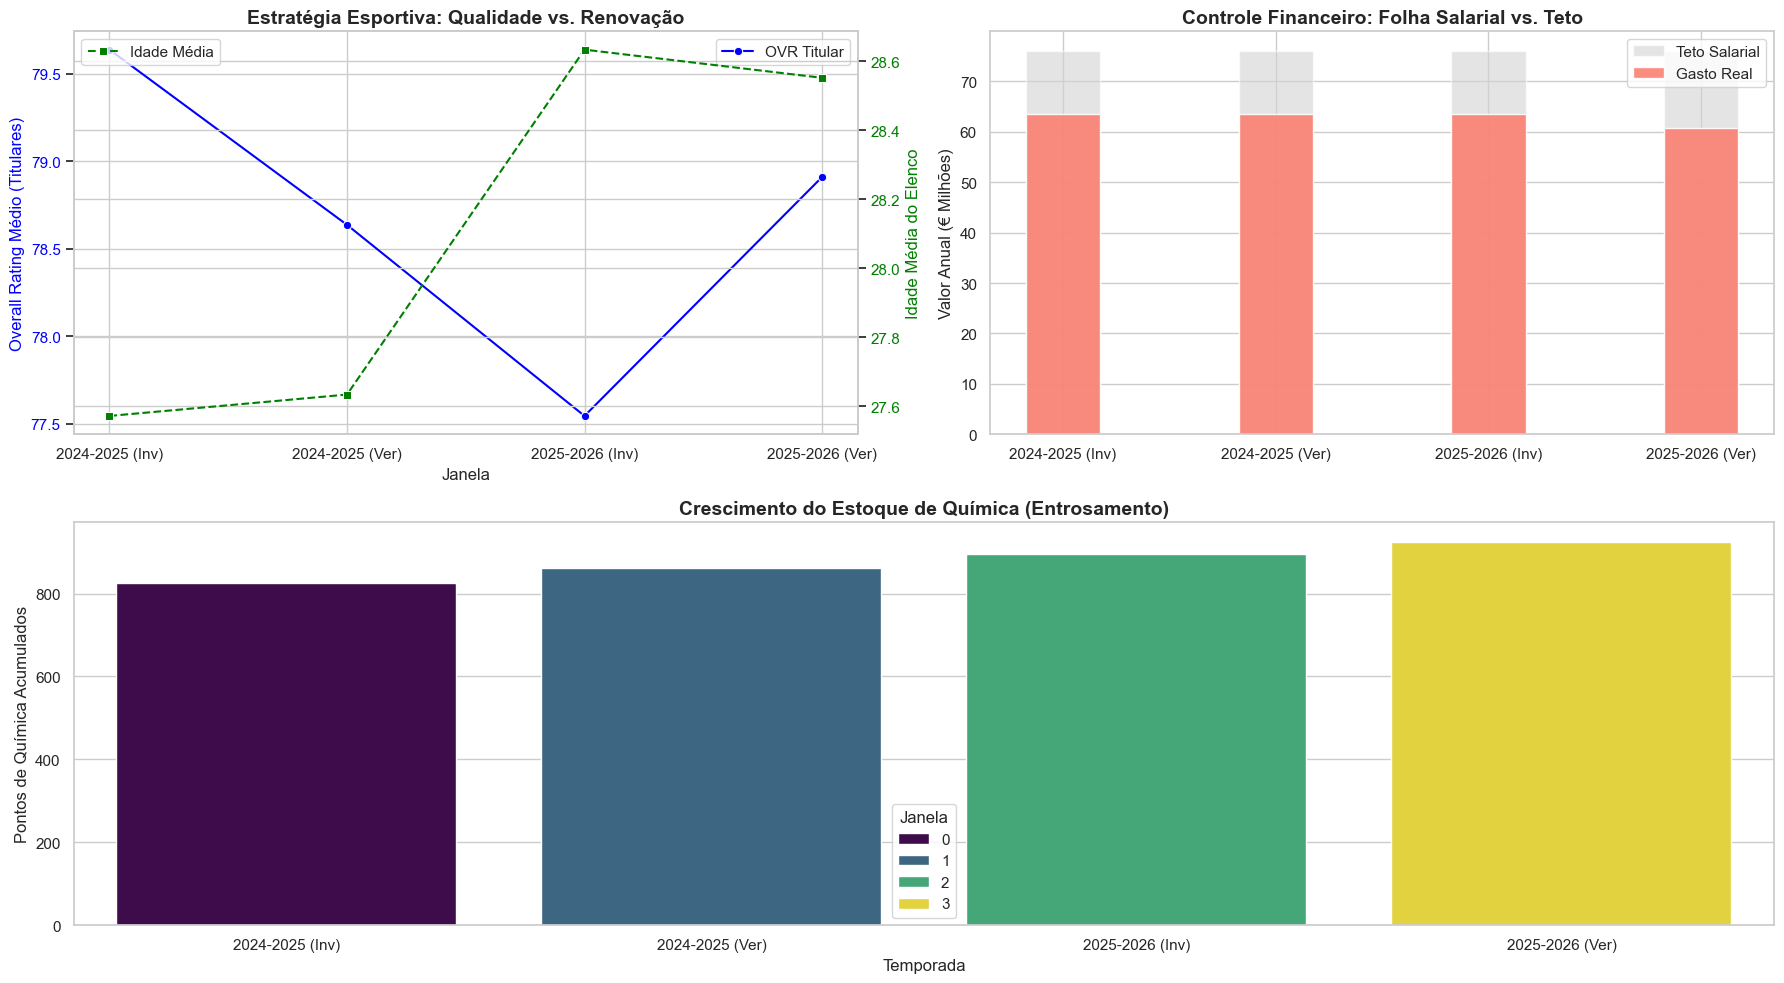

Gráficos gerados. Observe como a química (gráfico inferior) tende a crescer exponencialmente se o elenco for mantido.


In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- [PIPELINE DE VISUALIZAÇÃO] ---

def gerar_graficos_resultados():
    if pulp.LpStatus[model.status] != 'Optimal' and pulp.LpStatus[model.status] != 'Undefined':
        print("O modelo não foi resolvido. Pule esta etapa.")
        return

    # 1. Extração de Dados do Solver para DataFrame
    dados_grafico = []
    
    for t in JANELAS:
        # Jogadores no elenco em t
        elenco_t_ids = [i for i in todos_os_ids 
                       if no_elenco_vars[i, t].varValue is not None and no_elenco_vars[i, t].varValue > 0.9]
        
        # Titulares em t
        titulares_t_ids = [i for i in todos_os_ids 
                          if titular_vars[i, t].varValue is not None and titular_vars[i, t].varValue > 0.9]
        
        # Estatísticas Agregadas
        ovr_medio_titular = np.mean([dados_temporais[i][t]['overall_rating'] for i in titulares_t_ids])
        idade_media = np.mean([dados_temporais[i][t]['age'] for i in elenco_t_ids])
        folha_salarial = sum([dados_temporais[i][t]['wage_eur'] * 52 for i in elenco_t_ids])
        
        # Química Total
        quimica_total = 0
        for (i, j) in pares_relevantes:
             if Quimica[(i, j, t)].varValue:
                 quimica_total += Quimica[(i, j, t)].varValue
        
        dados_grafico.append({
            'Janela': t,
            'Temporada': f"{2024 + t//2}-{2025 + t//2} ({'Inv' if t%2==0 else 'Ver'})",
            'OVR Titular': ovr_medio_titular,
            'Idade Média': idade_media,
            'Folha Salarial (€M)': folha_salarial,
            'Teto Salarial (€M)': WAGE_BUDGET_YEAR,
            'Química Total': quimica_total
        })
    
    df_res = pd.DataFrame(dados_grafico)

    # --- CONFIGURAÇÃO DO ESTILO ---
    sns.set_theme(style="whitegrid")
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 2)

    # GRÁFICO 1: Evolução Técnica (Qualidade vs Idade)
    ax1 = fig.add_subplot(gs[0, 0])
    sns.lineplot(data=df_res, x='Janela', y='OVR Titular', marker='o', color='blue', label='OVR Titular', ax=ax1)
    ax1.set_ylabel('Overall Rating Médio (Titulares)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    ax2 = ax1.twinx()
    sns.lineplot(data=df_res, x='Janela', y='Idade Média', marker='s', color='green', linestyle='--', label='Idade Média', ax=ax2)
    ax2.set_ylabel('Idade Média do Elenco', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax1.set_title('Estratégia Esportiva: Qualidade vs. Renovação', fontsize=14, fontweight='bold')
    ax1.set_xticks(df_res['Janela'])
    ax1.set_xticklabels(df_res['Temporada'])

    # GRÁFICO 2: Saúde Financeira
    ax3 = fig.add_subplot(gs[0, 1])
    
    # Plotando Teto e Gasto
    bar_width = 0.35
    index = df_res['Janela']
    
    ax3.bar(index, df_res['Teto Salarial (€M)'], bar_width, label='Teto Salarial', color='lightgray', alpha=0.6)
    ax3.bar(index, df_res['Folha Salarial (€M)'], bar_width, label='Gasto Real', color='salmon', alpha=0.9)
    
    ax3.set_title('Controle Financeiro: Folha Salarial vs. Teto', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Valor Anual (€ Milhões)')
    ax3.set_xticks(index)
    ax3.set_xticklabels(df_res['Temporada'])
    ax3.legend()

    # GRÁFICO 3: Evolução da Química
    ax4 = fig.add_subplot(gs[1, :]) # Ocupa a largura inteira embaixo
    sns.barplot(data=df_res, x='Temporada', y='Química Total', hue='Janela', palette='viridis', ax=ax4)
    ax4.set_title('Crescimento do Estoque de Química (Entrosamento)', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Pontos de Química Acumulados')
    
    plt.tight_layout()
    plt.show()
    
    print("Gráficos gerados. Observe como a química (gráfico inferior) tende a crescer exponencialmente se o elenco for mantido.")

# Chama a função
gerar_graficos_resultados()

## 5. Discussão e Conclusão

O modelo desenvolvido foi capaz de gerar um plano de gestão de elenco coerente, respeitando restrições financeiras complexas e táticas. No entanto, como toda modelagem matemática, existem simplificações que devem ser consideradas:

### 5.1. Limitações do Modelo

* **Determinismo:** O modelo assume que os jogadores evoluirão exatamente conforme as curvas projetadas. Na realidade, lesões ou má fase são fatores estocásticos imprevisíveis. Uma abordagem via **Programação Estocástica** seria mais robusta.

* **Linearidade da Performance:** Assumimos que a força do time é a soma das habilidades individuais + química de pares. O futebol real possui dinâmicas não-lineares complexas.

* **Complexidade Computacional:** A inclusão da variável de Química ($Q_{i,j,t}$) cria uma dependência quadrática ($O(N^2)$). Para contornar isso, utilizamos técnicas de "poda" (selecionando apenas os pares mais relevantes), mas para bases de dados maiores, heurísticas como **Meta-heurísticas (Algoritmo Genético)** poderiam ser necessárias.

### 5.2. Trabalhos Futuros
Para expandir este projeto, sugerem-se as seguintes melhorias:

1.  Incluir restrições de **jogadores estrangeiros** (comuns no Brasil e Europa).

2.  Modelar a **probabilidade de lesão** baseada no atributo "Physical".

3.  Implementar uma interface visual para que um diretor de futebol pudesse simular cenários ("E se o orçamento cair pela metade?").
